<a href="https://colab.research.google.com/github/SCaRreC/Deep_learning/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
!git clone https://github.com/SCaRreC/Deep_learning.git


fatal: destination path 'Deep_learning' already exists and is not an empty directory.


In [65]:
# Libraries and initial configuration

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import cv2
from torchvision import transforms
import os
import random
from PIL import Image
import torch
#import sys
#sys.path.insert(0, '/content/drive/MyDrive/Bootcamp/Deep_learning/src')
#from utils import fit_transform_features, transform_features, ds_poi
from Deep_learning.src.utils import *
import joblib


In [ ]:
# Data load
csv_path = os.path.join('Deep_learning', 'data', 'raw', 'poi_dataset.csv')
df_poi = pd.read_csv(csv_path)
# process raw data
df_poi_processed = data_processing(df_poi)
df_poi_processed.head(5).T

In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


set_seed(42)

In [71]:

# Data load
csv_path = os.path.join('Deep_learning', 'data', 'raw', 'poi_dataset.csv')
df_poi = pd.read_csv(csv_path)
#df_poi = pd.read_csv('/content/drive/MyDrive/Bootcamp/Deep_learning/data/raw/poi_dataset.csv')
# visualize first rows
print(df_poi.shape)
df_poi.head(5)

(1569, 14)


,id,name,shortDescription,categories,tier,locationLon,locationLat,tags,xps,Visits,Likes,Dislikes,Bookmarks,main_image_path
0,4b36a3ed-3b28-4bc7-b975-1d48b586db03,Galería Fran Reus,La Galería Fran Reus es un espacio dedicado a ...,"['Escultura', 'Pintura']",1,2.642262,39.572694,[],500,10009,422,3582,78,data_main/4b36a3ed-3b28-4bc7-b975-1d48b586db03...
1,e32b3603-a94f-49df-8b31-92445a86377c,Convento de San Plácido,"El Convento de San Plácido en Madrid, fundado ...","['Patrimonio', 'Historia']",1,-3.704467,40.423037,[],500,10010,7743,96,2786,data_main/e32b3603-a94f-49df-8b31-92445a86377c...
2,0123a69b-13ac-4b65-a5d5-71a95560cff5,Instituto Geológico y Minero de España,"El Instituto Geológico y Minero de España, sit...","['Ciencia', 'Patrimonio']",2,-3.699694,40.442045,[],250,10015,3154,874,595,data_main/0123a69b-13ac-4b65-a5d5-71a95560cff5...
3,390d7d9e-e972-451c-b5e4-f494af15e788,Margarita Gil Roësset,"Margarita Gil Roësset, escultora y poetisa esp...",['Cultura'],1,-3.691228,40.427256,[],500,10011,8559,79,2358,data_main/390d7d9e-e972-451c-b5e4-f494af15e788...
4,023fc1bf-a1cd-4b9f-af78-48792ab1a294,Museo del Traje. Centro de Investigación del P...,"El Museo del Traje de Madrid, fundado en 2004,...","['Patrimonio', 'Cultura']",1,-3.727822,40.439665,[],500,10020,915,2896,143,data_main/023fc1bf-a1cd-4b9f-af78-48792ab1a294...


# Division of Dataset

In [ ]:
from sklearn.model_selection import train_test_split

X = df_poi.drop(columns=['engagement', 'engagement_score'])
y = df_poi['engagement_score']

# Divide train and test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify= y,
    random_state = seed,
)
# Divide validation subset
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    stratify=y_train,
    random_state = seed,
)


In [98]:
print("\nConteo absoluto en TRAIN:")
print(y_train.value_counts())

print("\nConteo absoluto en VALIDACIÓN:")
print(y_val.value_counts())

print("\nConteo absoluto en TEST:")
print(y_test.value_counts())



Conteo absoluto en TRAIN:
engagement_score
0    335
2    335
1    334
Name: count, dtype: int64

Conteo absoluto en VALIDACIÓN:
engagement_score
0    84
1    84
2    83
Name: count, dtype: int64

Conteo absoluto en TEST:
engagement_score
1    105
2    105
0    104
Name: count, dtype: int64


## Create the dataset custom


In [100]:
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from torchvision import transforms

In [ ]:
# Transformations for images
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [104]:
class ds_poi(Dataset):
  """
  Class that facilitates dataset processing to load it into de DataLoader.
  it needs:
  - Initialize the dataset
  - get the length of the data set
  - obtain every item in the dataset
  """

  def __init__(self, target, image_path, features, transform=None):
    assert len(target) == len(image_path) == len(features)
    # assert que target y features sean np.array o tensor
    self.target = torch.tensor(target, dtype=torch.long)
    #processed_features = process_features(features)
    self.features = torch.tensor(features, dtype=torch.float32)
    self.image_path = image_path
    self.transform = transform

  def __len__(self):
    return len(self.features)


  def __getitem__(self, idx):
    target = self.target[idx]
    features = self.features[idx]
    im = cv2.imread(self.image_path[idx])
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = Image.fromarray(im)
    if self.transform is not None:
      im = self.transform(im)

    return target, features, im

In [ ]:
# standarization
scaler, X_train_scaled = fit_transform_features(X_train.drop(columns=['main_image_path']))
X_val_scaled = transform_features(X_val.drop(columns=['main_image_path']), scaler)
X_test_scaled = transform_features(X_test.drop(columns=['main_image_path']), scaler)

# target
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()

# images
img_train = X_train['main_image_path']
img_val = X_val['main_image_path']
img_test = X_test['main_image_path']

img_train = img_train.transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
img_val = img_val.transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
img_test = img_test.transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print(X_train_scaled)
print(type(y_train))
print(type(img_train))

[[-0.85071917  0.99427137  1.01611293 ...  1.82929504 -0.18144368
  -1.63081285]
 [-0.85071917 -0.16684658  0.18691516 ...  1.82929504 -0.18144368
  -0.32512218]
 [ 0.70505869 -0.12071533  0.05811401 ... -0.54665867 -0.18144368
   0.32772316]
 ...
 [-0.85071917 -0.12125526  0.05868812 ... -0.54665867  5.51135192
  -1.41319774]
 [-0.85071917 -0.12039985  0.05743463 ... -0.54665867 -0.18144368
   0.32772316]
 [ 0.70505869 -0.11935126  0.05979231 ... -0.54665867 -0.18144368
   0.98056849]]
<class 'numpy.ndarray'>
<class 'list'>


In [ ]:
# save all preprocessed data for modeling after.
"""
import joblib

os.makedirs('data/processed', exist_ok=True)

np.save('data/processed/X_train_scaled.npy', X_train_scaled)
np.save('data/processed/X_val_scaled.npy', X_val_scaled)
np.save('data/processed/X_test_scaled.npy', X_test_scaled)

np.save('data/processed/y_train.npy', y_train)
np.save('data/processed/y_val.npy', y_val)
np.save('data/processed/y_test.npy', y_test)

joblib.dump(img_train, 'data/processed/img_train.pkl')
joblib.dump(img_val, 'data/processed/img_val.pkl')
joblib.dump(img_test, 'data/processed/img_test.pkl')

joblib.dump(scaler, 'data/processed/scaler.pkl')
"""

['data/processed/scaler.pkl']

In [108]:
#!zip -r processed_data.zip data/processed/
#from google.colab import files
#files.download('processed_data.zip')


In [ ]:

# Datasets
train_dataset = ds_poi(y_train,  X_train_scaled, img_train)
val_dataset = ds_poi(y_val, X_val_scaled, img_val)
test_dataset = ds_poi(y_test, X_test_scaled, img_test)


In [110]:
batch_size = 32
num_features = X_train_scaled.shape[1]
num_classes = 3

In [ ]:
# Create DataLoaders

generator = torch.Generator()
generator.manual_seed(seed)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=generator, worker_init_fn=lambda x: np.random.seed(seed))
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, generator=generator, worker_init_fn=lambda x: np.random.seed(seed))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, generator=generator, worker_init_fn=lambda x: np.random.seed(seed))

## Sanity check

Targets shape: torch.Size([32])
Features shape: torch.Size([32, 17])
Images shape: torch.Size([32, 3, 128, 128])


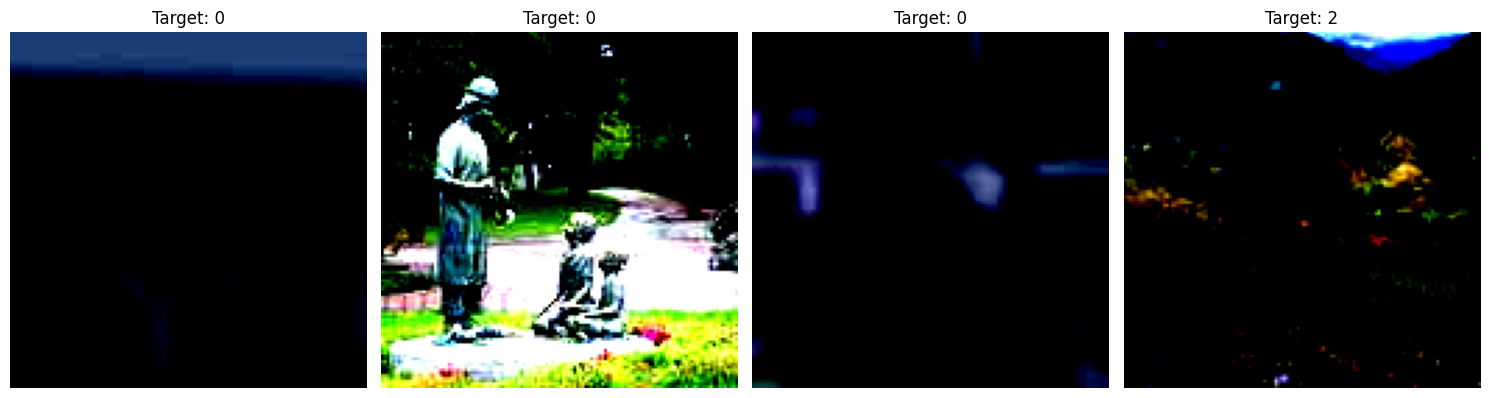

In [112]:
def show_sanity_batch(train_loader, class_labels=None):
    for batch in train_loader:
        targets, features, images = batch

        print("Targets shape:", targets.shape)
        print("Features shape:", features.shape)
        print("Images shape:", images.shape)

        # Mostrar las primeras 4 imágenes del batch
        images_np = images[:4].permute(0, 2, 3, 1).numpy()  # de [B, C, H, W] a [B, H, W, C]
        targets_np = targets[:4].numpy()

        fig, axs = plt.subplots(1, 4, figsize=(15, 5))
        for i in range(4):
            img = images[i].permute(1, 2, 0).numpy()  # De (C, H, W) a (H, W, C)
            axs[i].imshow(img)
            label = targets[i].item()
            axs[i].set_title(f'Target: {class_labels[label] if class_labels else label}')
            axs[i].axis('off')
        plt.tight_layout()
        plt.show()
        break  # Solo mostramos el primer batch

# Ejemplo de uso
show_sanity_batch(train_loader, class_labels=[0, 1, 2])

# Model

In [ ]:
from transformers import AutoImageProcessor, AutoModelForImageClassification
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models
import numpy as np
import torchvision
from PIL import Image

In [114]:

# Modelo hibrido definido antes
class HybridModel(nn.Module):
    def __init__(self, num_features, num_classes):
        super(HybridModel, self).__init__()

        # Imagen: ResNet18 sin capa final
        self.cnn = torchvision.models.resnet18(pretrained=True)
        for param in self.cnn.parameters():
            param.requires_grad = False  # freeze layers

        self.cnn_res = nn.Sequential(*list(self.cnn.children())[:-1])  # removes last layer (classificator)
        self.cnn_output_size = self.cnn.fc.in_features  # por ejemplo, 512

        # Features tabulares
        self.feat = nn.Sequential(
            #nn.Flatten(),
            nn.Linear(num_features, 64),
            nn.BatchNorm1d(64), # Speeds net's learning speed
            nn.ReLU(),
            nn.Dropout(0.3), # turns off some neurons during training to make the net more robust
            nn.Linear(64, 32),
            nn.ReLU()
        )

        # Clasificador final
        self.classifier = nn.Sequential(
            nn.Linear(self.cnn_output_size + 32, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),

            nn.Linear(32, num_classes)  # salida: 3 clases

        )

    def forward(self, features, images):
        #print(">> Inside forward - features.shape:", features.shape)
        x_img = self.cnn_res(images)        # [B, 512, 1, 1]
        x_img = x_img.view(x_img.size(0), -1)    # [B, 512]
        x_feat = self.feat(features)
        x = torch.cat((x_img, x_feat), dim=1)

        out = self.classifier(x)
        return out


In [115]:
# Initiate the model
num_features = X_train_scaled.shape[1] # Assuming X_train_scaled is your feature array
num_classes = len(np.unique(y_train)) # Assuming y_train is your target array

# Instantiate the HybridModel
model = HybridModel(num_features=num_features, num_classes=num_classes)

# Move the model to the appropriate device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


HybridModel(
  (cnn): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

In [116]:
# model structure

print(HybridModel)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)


<class '__main__.HybridModel'>


# Training

In [ ]:
# optimizer and loss function
criterion = torch.nn.CrossEntropyLoss()
l2_lambda = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay= l2_lambda)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Entrenamiento
num_epochs = 10
train_losses, train_accs, val_losses, val_accs = [], [], [], []

for epoch in range(num_epochs):
    # Entrenamiento con las funciones adaptadas
    train_loss, train_acc, lr = train_epoch(
        model, device, train_loader, criterion,
        optimizer, l1_lambda=None, scheduler=scheduler
    )

    # Validación con la función adaptada
    val_loss, val_acc = eval_epoch(
        model, device, val_loader, criterion
    )

    # Guardamos métricas
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
    print(f'Learning Rate: {lr:.6f}\n')

# Evaluación final (necesitarías adaptar también evaluate_model si la usas)
# Asumiendo que evaluate_model sigue la misma estructura que eval_epoch
_, test_acc = eval_epoch(model, device, test_loader, criterion)
print(f'Test Accuracy: {test_acc:.2f}%')

# Visualización (asegúrate de que plot_training_curves esté definida)
plot_training_curves(train_losses, val_losses, train_accs, val_accs, num_epochs, test_acc=test_acc)

Gráfico de la izquierda: Pérdida (Loss)
Train Loss (línea roja): es la pérdida en el conjunto de entrenamiento. Está bajando de forma constante, lo que indica que el modelo está aprendiendo a predecir mejor sobre los datos con los que se entrena.
Validation Loss (línea azul): es la pérdida sobre el conjunto de validación. Se mantiene bastante constante o incluso con pequeñas subidas, lo cual es una señal de alerta.
¿Qué significa esto?

Tu modelo está mejorando sobre el entrenamiento, pero no mejora sobre la validación.
Posible indicio de sobreajuste (overfitting): el modelo se adapta muy bien a los datos de entrenamiento, pero no generaliza bien a nuevos datos.
📈 Gráfico de la derecha: Precisión (Accuracy)
Train Accuracy (línea roja): la precisión en el entrenamiento va subiendo, incluso superando el 90%.
Validation Accuracy (línea azul): se mantiene estable, alrededor del 82-84%, sin mejorar.
Test Accuracy (línea punteada roja): aparece en cero. Esto sugiere que no se ha evaluado el test aún o que hay un error al graficarlo.
¿Qué significa esto?

Nuevamente vemos que el modelo se comporta bien con el entrenamiento pero no mejora en validación. Otro indicio de sobreajuste.
La línea roja (Train Accuracy) es mucho más alta que la azul (Validation Accuracy), lo cual es típico cuando el modelo memoriza los datos en lugar de generalizar.

Now I am going to try to change the Dropout layers to a higher value and add normalization layer to the dense net for the features.

In [131]:

# Modelo hibrido definido antes
class HybridModel(nn.Module):
    def __init__(self, num_features, num_classes):
        super(HybridModel, self).__init__()

        # Imagen: ResNet18 sin capa final
        self.cnn = torchvision.models.resnet18(pretrained=True)
        for param in self.cnn.parameters():
            param.requires_grad = False  # freeze layers

        self.cnn_res = nn.Sequential(*list(self.cnn.children())[:-1])  # removes last layer (classificator)
        self.cnn_output_size = self.cnn.fc.in_features  # por ejemplo, 512

        # Features tabulares
        self.feat = nn.Sequential(
            #nn.Flatten(),
            nn.Linear(num_features, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.5), # increased from 0.3 to 0.5
            nn.Linear(64, 32),
            nn.BatchNorm1d(32), #added an extra normalization layer
            nn.ReLU(),
            nn.Dropout(0.3) # added another Dropout layer
        )

        # Clasificador final
        self.classifier = nn.Sequential(
            nn.Linear(self.cnn_output_size + 32, 64),
            nn.ReLU(),
            nn.Dropout(0.4), #increased dropout value
            nn.Linear(64, 32),
            nn.ReLU(),

            nn.Linear(32, num_classes)  # salida: 3 clases

        )

    def forward(self, features, images):
        #print(">> Inside forward - features.shape:", features.shape)
        x_img = self.cnn_res(images)        # [B, 512, 1, 1]
        x_img = x_img.view(x_img.size(0), -1)    # [B, 512]
        x_feat = self.feat(features)
        x = torch.cat((x_img, x_feat), dim=1)

        out = self.classifier(x)
        return out
# Instantiate the HybridModel
model = HybridModel(num_features=num_features, num_classes=num_classes)

# Move the model to the appropriate device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


HybridModel(
  (cnn): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

Epoch 1/10
Train Loss: 1.0610 | Train Acc: 43.13%
Val Loss: 0.9710 | Val Acc: 60.96%
Learning Rate: 0.001000

Epoch 2/10
Train Loss: 0.9339 | Train Acc: 56.08%
Val Loss: 0.8138 | Val Acc: 66.93%
Learning Rate: 0.001000

Epoch 3/10
Train Loss: 0.7785 | Train Acc: 66.43%
Val Loss: 0.5944 | Val Acc: 76.49%
Learning Rate: 0.001000

Epoch 4/10
Train Loss: 0.6186 | Train Acc: 74.40%
Val Loss: 0.4919 | Val Acc: 80.48%
Learning Rate: 0.001000

Epoch 5/10
Train Loss: 0.5626 | Train Acc: 76.69%
Val Loss: 0.4502 | Val Acc: 80.48%
Learning Rate: 0.000100

Epoch 6/10
Train Loss: 0.4909 | Train Acc: 81.18%
Val Loss: 0.4578 | Val Acc: 79.68%
Learning Rate: 0.000100

Epoch 7/10
Train Loss: 0.4920 | Train Acc: 81.08%
Val Loss: 0.4544 | Val Acc: 79.68%
Learning Rate: 0.000100

Epoch 8/10
Train Loss: 0.4780 | Train Acc: 82.87%
Val Loss: 0.4560 | Val Acc: 80.48%
Learning Rate: 0.000100

Early stopping!
Test Accuracy: 80.89%


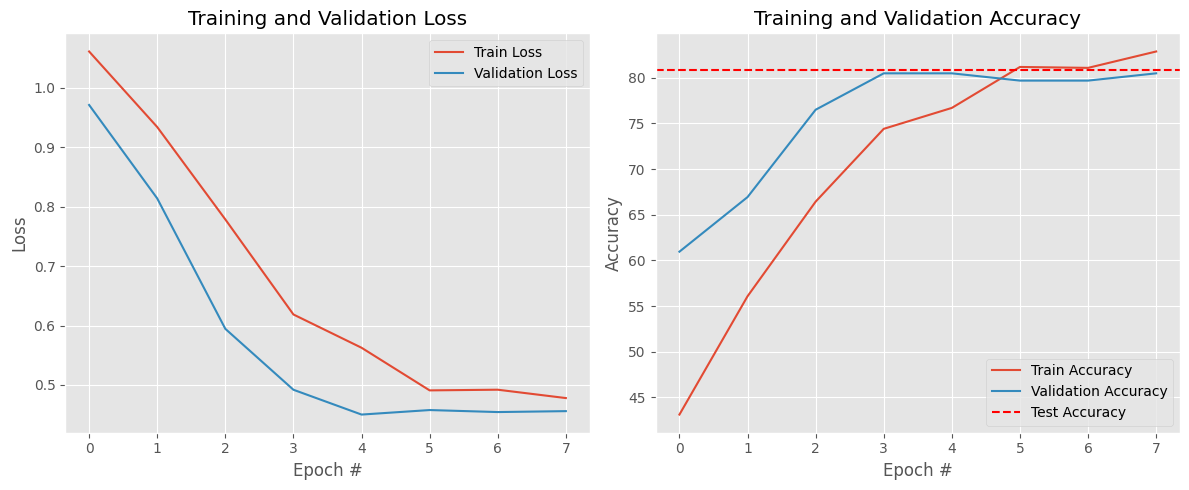

In [132]:
# optimizer and loss function
criterion = torch.nn.CrossEntropyLoss()
l2_lambda = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay= l2_lambda)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Entrenamiento
num_epochs = 10
train_losses, train_accs, val_losses, val_accs = [], [], [], []
best_val_loss = float('inf')
patience = 3 # number of epochs where the val_loss > train_loss
epochs_no_improve = 0

for epoch in range(num_epochs):
    # Entrenamiento con las funciones adaptadas
    train_loss, train_acc, lr = train_epoch(
        model, device, train_loader, criterion,
        optimizer, l1_lambda=None, scheduler=scheduler
    )

    # Validación con la función adaptada
    val_loss, val_acc = eval_epoch(
        model, device, val_loader, criterion
    )

    # Guardamos métricas
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
    print(f'Learning Rate: {lr:.6f}\n')

    # Implemented early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        # Guarda el mejor modelo
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print("Early stopping!")
            break

# Evaluación final (necesitarías adaptar también evaluate_model si la usas)
# Asumiendo que evaluate_model sigue la misma estructura que eval_epoch
_, test_acc = eval_epoch(model, device, test_loader, criterion)
print(f'Test Accuracy: {test_acc:.2f}%')

# Visualización (asegúrate de que plot_training_curves esté definida)
plot_training_curves(train_losses, val_losses, train_accs, val_accs, len(train_losses), test_acc=test_acc)

At this point, I decided that I wanted to explore the hiperparameters optimization using Optuna, to see if the model would increase in accuracy for validation subset, but I realized I was trying to parametrizate too many parameters at once, for the first time, so decided to do it over a simplerer model, so this part continues in the notebook 'optimization_simplified_model'